In [1]:
# Include parent directory in sys.path to import local modules
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [3]:
from src.io import load_from_hdf5, load_key_from_hdf5
import numpy as np
from matplotlib import pyplot as plt

## Setting the filename

In [123]:
dt = 0.1
p = 0.15
Nx = 4
Ny = 4
N = Nx*Ny
b = 0.0 #2/((Nx-1)*(Ny-1))  # Magnetic field strength
B = b*np.pi # Magnetic field in units of flux quantum
t = 0.0  # Diagonal hopping
num_iterations = 1000
steps = 200
site_in = 0  # Site where the current is injected
site_out = N-1  # Site where the current is extracted
drive_type = "current"  # "current", "dephasing"
corner_dephasing = False  # Whether to apply dephasing at the corners
initial_state = "random"  # "checkerboard", "empty", "random", "custom"


filename = f"ff_{Nx}x{Ny}_dt{dt}_p{p}_B{B}_t{t}_steps{steps}_trajectories{num_iterations}_{drive_type}_{initial_state}"

---
# Plotting Density Trace

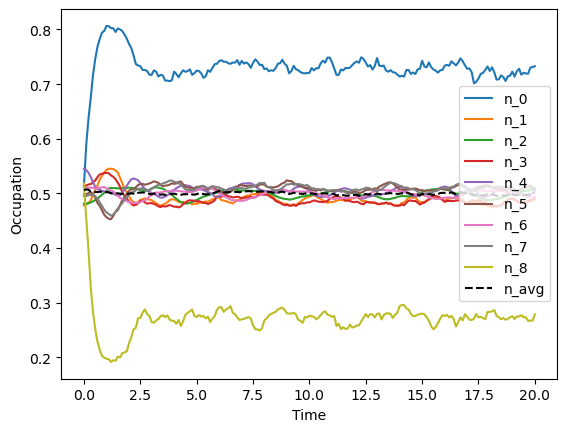

In [26]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny


for i in range(N):
    plt.plot(t_list, n_avg[:,i], label=f"n_{i}")
plt.plot(t_list, np.sum(n_avg, axis=1)/N, '--', c='k', label="n_avg")
plt.xlabel("Time")
plt.ylabel("Occupation")
plt.legend()




## Log-plot of densities

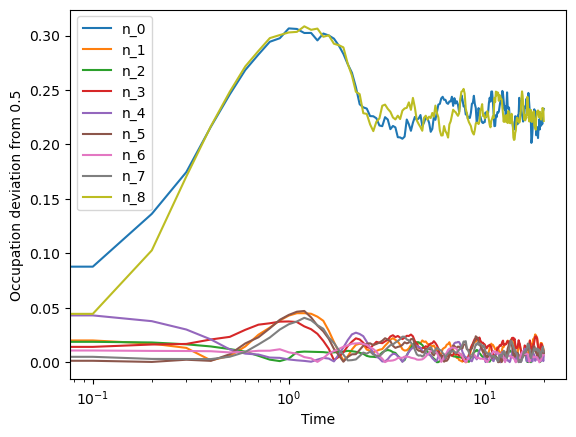

In [22]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny

for i in range(N):
    plt.plot(t_list, np.abs(n_avg[:,i]-0.5), label=f"n_{i}")
plt.xlabel("Time")
plt.ylabel("Occupation deviation from 0.5")
plt.legend()
plt.xscale("log")


---
# Current trace

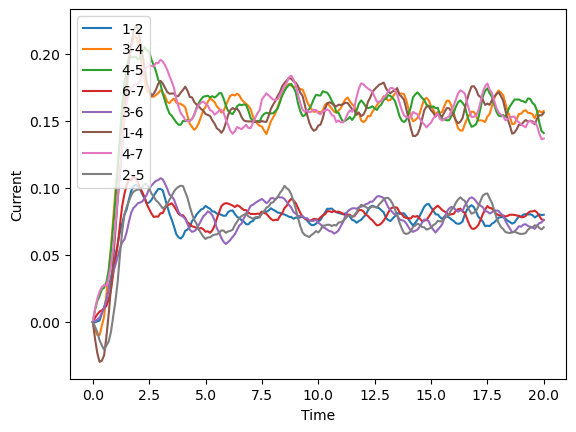

In [30]:
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

for i, bond in enumerate(bonds):
    plt.plot(t_list, avg_currents[:,i], label=f"{bond[0]}-{bond[1]}")
plt.xlabel("Time")
plt.ylabel("Current")
plt.legend()
plt.show()

---
# NESS Snapshot

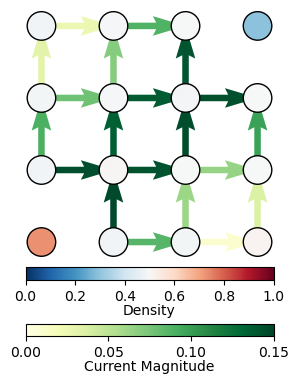

In [124]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U = []; V = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = bond[0] % Nx, bond[0] // Nx
    x2, y2 = bond[1] % Nx, bond[1] // Nx

    if np.abs(avg_currents[-1,i]) > plotting_threshold*np.abs(avg_currents[-1,:]).max():
        C.append(np.abs(avg_currents[-1,i]))

        if np.real(avg_currents[-1,i]) > 0:
            X.append(x1)
            Y.append(y1)
            U.append(x2-x1)
            V.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U.append(x1-x2)
            V.append(y1-y2)

fig, ax = plt.subplots()

p1 = ax.quiver(X, Y, U, V, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, 0.15)#np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(n_avg[-1,n])

p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1 * 3/Nx)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

# Time-Averaged Snapshot

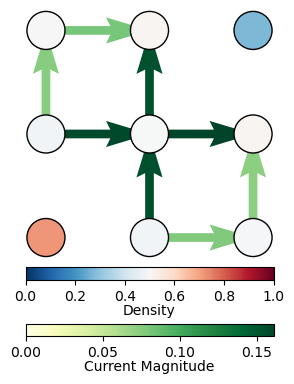

In [115]:
n_avg = load_key_from_hdf5(f"../data/{filename}.h5", "n_avg")
avg_currents = load_key_from_hdf5(f"../data/{filename}.h5", "avg_currents")
params = load_key_from_hdf5(f"../data/{filename}.h5", "params")
t_list = load_key_from_hdf5(f"../data/{filename}.h5", "t_list")

# Extract parameters
Nx = params['Nx']
Ny = params['Ny']
N = Nx * Ny
bonds = params['bonds']

plotting_threshold = 0.0  # Threshold for plotting currents
marker_size = 750 * (3/Nx)**2  # Size of the markers for the density plot
arrow_width = 0.035 * 3/Nx  # Width of the arrows in the quiver plot


time_averaged_currents = np.mean(avg_currents[7*steps//8:-1], axis=0)
time_averaged_n = np.mean(n_avg[7*steps//8:-1], axis=0)

# single line definition of empty lists for X, Y, U, V, C
X = []; Y = []; U = []; V = []; C = []
for i, bond in enumerate(bonds):
    # convert back from n to x,y coordinates
    x1, y1 = bond[0] % Nx, bond[0] // Nx
    x2, y2 = bond[1] % Nx, bond[1] // Nx

    if np.abs(time_averaged_currents[i]) > plotting_threshold*np.abs(time_averaged_currents).max():
        C.append(np.abs(time_averaged_currents[i]))

        if np.real(time_averaged_currents[i]) > 0:
            X.append(x1)
            Y.append(y1)
            U.append(x2-x1)
            V.append(y2-y1)
        else:
            X.append(x2)
            Y.append(y2)
            U.append(x1-x2)
            V.append(y1-y2)

fig,ax = plt.subplots()

p1 = ax.quiver(X, Y, U, V, C, cmap="YlGn", angles='xy', scale_units='xy', scale=1, width=arrow_width)
p1.set_clim(0, np.max(C))
cb1 = plt.colorbar(p1, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb1.set_label('Current Magnitude', labelpad=0)

X = []; Y = []; C = []
for x in range(Nx):
    for y in range(Ny):
        n = x % Nx + y*Nx
        X.append(x)
        Y.append(y)
        C.append(time_averaged_n[n])


p2 = ax.scatter(X, Y, c=C, cmap="RdBu_r", s=marker_size, edgecolors= "black", vmin=0, vmax=1)
cb2 = plt.colorbar(p2, ax=ax, orientation='horizontal', shrink=0.5, pad=0.03)
cb2.set_label('Density', labelpad=0)

# Add automatic padding to prevent cutoff
ax.margins(0.1)  # Add padding around the data
# Alternatively, you could use: ax.set_xlim(-0.5, Nx-0.5); ax.set_ylim(-0.5, Ny-0.5)

ax.set_axis_off()
ax.set_aspect('equal')
plt.show()

# Density Correlation matrix

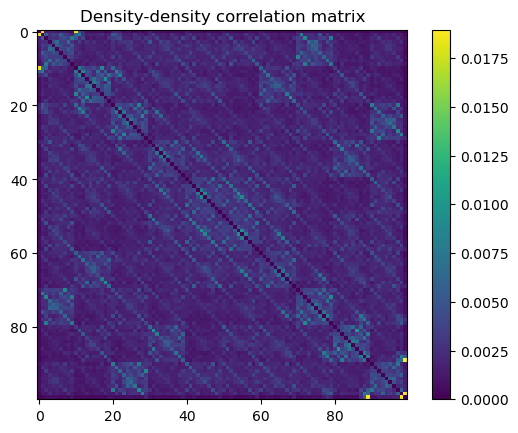

In [120]:
avg_dd_correlations = load_key_from_hdf5(f"../data/{filename}.h5", "avg_dd_correlations")

plt.imshow(np.abs(avg_dd_correlations - np.diag(np.diag(avg_dd_correlations))), cmap="viridis", vmin=0)
plt.colorbar()
plt.title("Density-density correlation matrix")
plt.show()